In [1]:
# Assuming your kernel autoinstalled renv, uncomment the following code
# to install the rest of the packages
# renv::restore()

In [2]:
library(renv)
library(GGally)
library(tidymodels)
library(tidyverse)
library(leaps)
library(caret)
library(boot)
library(pROC)
library(repr)
library(glmnet)


Attaching package: 'renv'


The following objects are masked from 'package:stats':

    embed, update


The following objects are masked from 'package:utils':

    history, upgrade


The following objects are masked from 'package:base':

    autoload, load, remove


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5      ✔ rsample      1.2.0 
✔ dials        1.2.0      ✔ tibble       3.2.1 
✔ dplyr        1.1.4      ✔ tidyr        1.3.0 
✔ infer        1.0.6      ✔ tune         1.1.2 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.0      ✔ workflowsets 1.0.1 
✔ purrr        1.0.2      ✔ yardstick    1.3.0 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::

In [3]:
articles <- read_csv('data/OnlineNewsPopularity.csv')

Rows: 39644 Columns: 61
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): url
dbl (60): timedelta, n_tokens_title, n_tokens_content, n_unique_tokens, n_no...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Exploratory Data Analysis

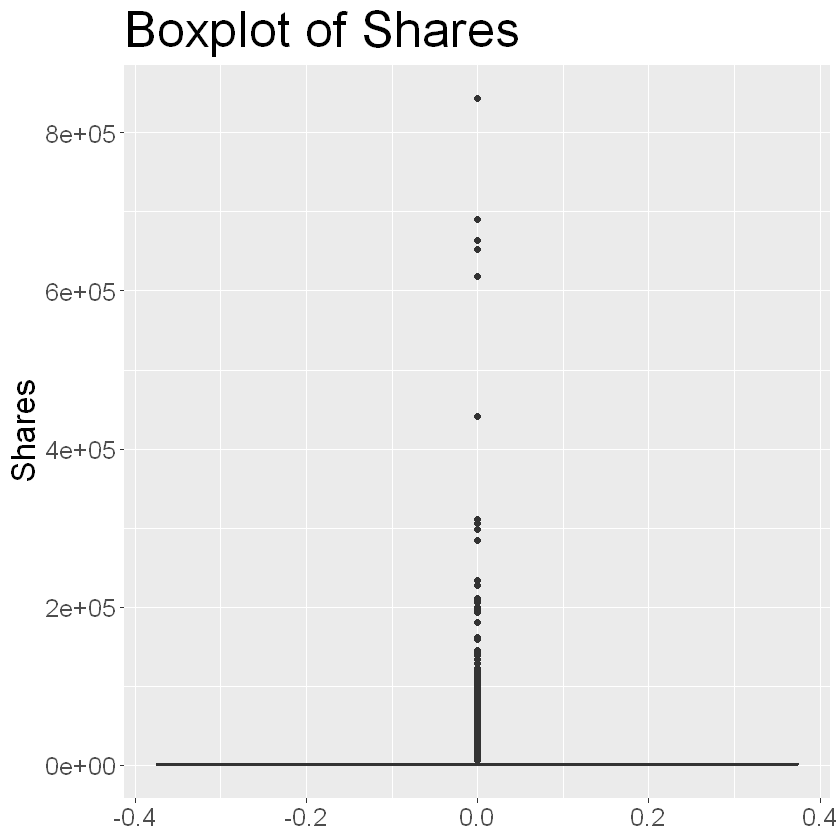

In [4]:
ggplot(data = articles) +
    geom_boxplot(aes(y = shares)) +
    labs(title = "Boxplot of Shares") +
    ylab(label = 'Shares') +
    theme(axis.title = element_text(size = 20), axis.text = element_text(size = 15), title = element_text(size = 25))

In [5]:
summary(articles$shares)
sd(articles$shares)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     946    1400    3395    2800  843300 

[1] 11626.95

The target variable is centered at 1400, while the spread is quite large, with a standard deviation of 11627. Therefore, we will adjust our work from regression to classification to determine whether an article will be popular. Our definition of an article being popular would to be above average, so an article will be classified as popular if its above 1400 shares, and will not be popular if below 1400.

In [6]:
articles_temp <- articles

drop_columns <- c('url')

articles_temp <- articles_temp[, !(names(articles_temp) %in% c(drop_columns))]#, one_hot_columns))]

articles_temp <- articles_temp |> mutate('shares' = ifelse(shares >= 1400, 1 , 0))

articles_clean <- articles_temp

In [7]:
write.csv(articles_clean, 'data/clean_Articles.csv')

In [8]:
set.seed(2024)

articles_clean$ID <- 1:nrow(articles_clean)

training_articles <- articles_clean |> slice_sample(prop = 0.7)

testing_articles <- anti_join(articles_clean, training_articles, by = "ID")


training_articles <- training_articles[, !(names(training_articles) %in% c('ID'))]
testing_articles <- testing_articles[, !(names(testing_articles) %in% c('ID'))]

head(training_articles, 3)
nrow(training_articles)

head(testing_articles, 3)
nrow(testing_articles)

timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
317,9,549,0.4935305,1,0.6827586,8,7,2,0,⋯,0.03333333,1,-0.2941358,-0.8,-0.125,0.5,0.5,0.0,0.5,1
338,9,452,0.5193622,1,0.6000000,18,1,13,0,⋯,0.10000000,1,-0.2171875,-0.4,-0.050,0.0,0.3,0.5,0.3,1
584,7,1361,0.3924890,1,0.6248237,8,3,1,1,⋯,0.03333333,1,-0.2574653,-1.0,-0.050,0.5,0.5,0.0,0.5,1


[1] 27750

timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
731,9,255,0.6047431,1,0.7919463,3,1,1,0,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0,0,0.5,0,0
731,9,211,0.5751295,1,0.6638655,3,1,1,0,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0,0,0.5,0,1
731,9,285,0.7441860,1,0.8415301,4,2,0,21,⋯,0.16000000,1.0,-0.3378889,-0.700,-0.1000000,1,-1,0.5,1,1


[1] 11894

In [9]:
write.csv(training_articles, 'data/training_data.csv')
write.csv(testing_articles, 'data/testing_data.csv')

Going to fit an initial linear model using all attributes to receive a baseline ordinary model for logistic regression. Using logistic regression since our target variable is a classification problem, and not a regression problem.

In [10]:
article_logistic_regression <- glm(shares ~ ., data = training_articles, family = binomial)

summary(article_logistic_regression)


Call:
glm(formula = shares ~ ., family = binomial, data = training_articles)

Coefficients: (2 not defined because of singularities)
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.845e+02  1.562e+03  -0.118 0.905980    
timedelta                      7.715e-06  8.787e-05   0.088 0.930032    
n_tokens_title                -2.600e-03  6.455e-03  -0.403 0.687091    
n_tokens_content               7.275e-05  5.219e-05   1.394 0.163391    
n_unique_tokens               -6.154e-01  4.315e-01  -1.426 0.153765    
n_non_stop_words               6.883e-01  1.501e+00   0.459 0.646503    
n_non_stop_unique_tokens      -1.409e-01  3.655e-01  -0.386 0.699815    
num_hrefs                      7.598e-03  1.583e-03   4.800 1.58e-06 ***
num_self_hrefs                -1.479e-02  4.323e-03  -3.420 0.000625 ***
num_imgs                       1.542e-03  2.038e-03   0.757 0.449320    
num_videos                    -1.821e-03  3.629e-03  -0.502 0.6

In [11]:
# Code adapted from UBC STAT 301 Lectures 12/13, Gabriela V. Cohen Freue 2022

misclassification_rate <- function(y, p.hat){
 y_hat <- round(p.hat, 0)
 error_rate <- sum(abs(y - y_hat) == 1) / length(y_hat)
 return(error_rate)
}

cv_logistic <-
 cv.glm(
 glmfit = article_logistic_regression,
 data = training_articles,
 K = 10,
 cost = misclassification_rate)

cv_logistic$delta[1]


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


[1] 0.3464505

Our training error is 0.346, which is large. The large training error could be due to multiple factors, such as the underlying distribution. Due to the amount of parameters, each case is likely to have an unique set of attribute values so it becomes more difficult for the model

In [12]:
articles_pred_class <- 
    round(predict(article_logistic_regression, newdata = training_articles, type = 'response'), 0)

head(articles_pred_class)

1 2 3 4 5 6 
1 1 1 0 1 0

In [13]:
articles_conf_mat <- 
        confusionMatrix(
            data = as.factor(articles_pred_class),
            reference = as.factor(training_articles$shares)
        )

articles_conf_mat

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  7890  4459
         1  5100 10301
                                          
               Accuracy : 0.6555          
                 95% CI : (0.6499, 0.6611)
    No Information Rate : 0.5319          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3062          
                                          
 Mcnemar's Test P-Value : 5.911e-11       
                                          
            Sensitivity : 0.6074          
            Specificity : 0.6979          
         Pos Pred Value : 0.6389          
         Neg Pred Value : 0.6689          
             Prevalence : 0.4681          
         Detection Rate : 0.2843          
   Detection Prevalence : 0.4450          
      Balanced Accuracy : 0.6526          
                                          
       'Positive' Class : 0               
                  

### TODO
Using our ordinary model as well as the training data, we predict whether an article is popular or not. Then we use that along with the true values for the confusion matrix, which shows ...

Setting levels: control = 0, case = 1

Setting direction: controls < cases



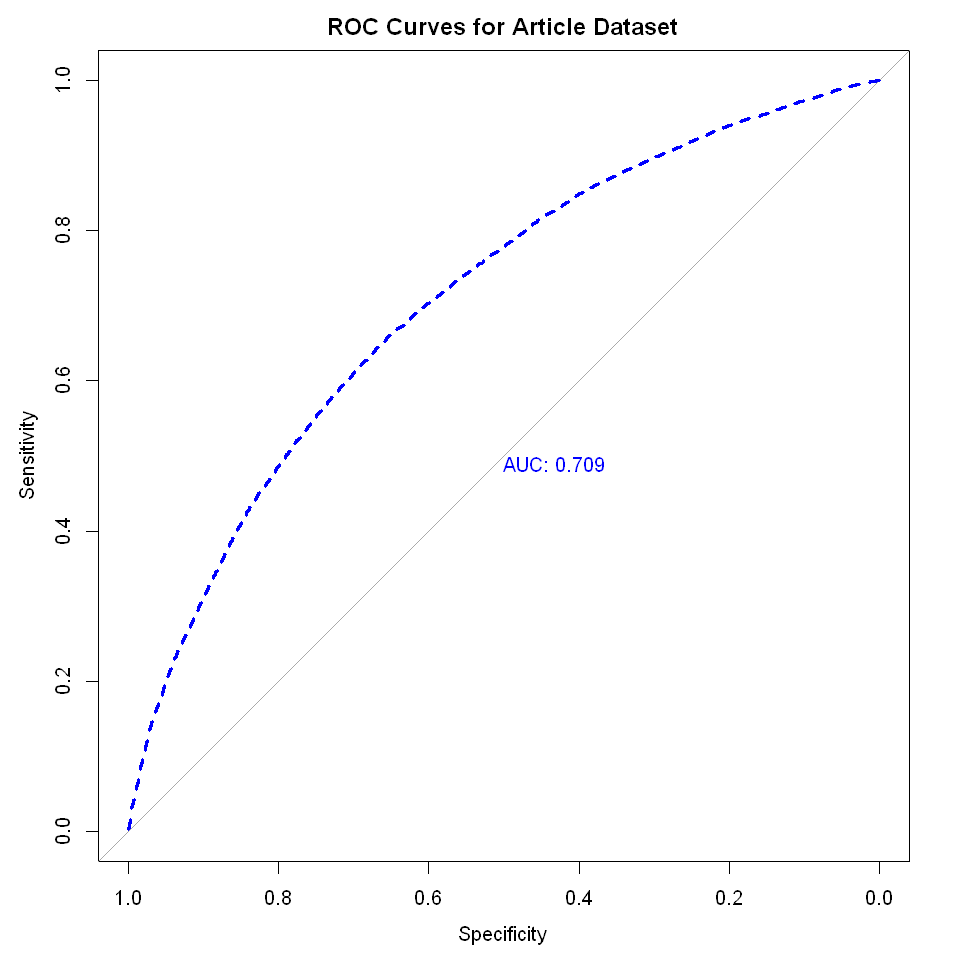

In [14]:
options(repr.plot.width = 8, repr.plot.height = 8)

ROC_full_log <- roc(
    response = training_articles$shares,
    predictor = predict(article_logistic_regression, type = 'response')
)

plot(ROC_full_log,
        print.auc = TRUE, col = 'blue', lwd = 3, lty = 2,
        main = 'ROC Curves for Article Dataset'
    )

In [15]:
auc_tibble <- tibble(Model = 'Full Model', AUC = as.double(ROC_full_log$auc))
auc_tibble

Model,AUC
<chr>,<dbl>
Full Model,0.7091242


The AUC for the model is 0.709, meaning that there is 70.9% chance that our model will be able to identify between a popular and unpopular article.

Since we have multiple attributes, we wish to find the most significant attributes that contribute the most to the amount of shares an article receives. We will do so using forward selection by way of the `tidymodels` package.

In [16]:
model_mat_X_train <-
    model.matrix(object = article_logistic_regression, data = training_articles)[, -1]

model_mat_Y_train <-
    as.matrix(training_articles$shares, ncol = 1)


In [17]:
articles_cv_lambda_lasso <- 
    cv.glmnet(
        x = model_mat_X_train, y = model_mat_Y_train,
        alpha = 1,
        family = 'binomial',
        type.measure = 'auc',
        nfolds = 5
    )
articles_cv_lambda_lasso


Call:  cv.glmnet(x = model_mat_X_train, y = model_mat_Y_train, type.measure = "auc",      nfolds = 5, alpha = 1, family = "binomial") 

Measure: AUC 

       Lambda Index Measure       SE Nonzero
min 0.0002829    62  0.7062 0.002039      52
1se 0.0028952    37  0.7042 0.002144      38

In [18]:
articles_lambda_1se_AUC_LASSO <- round(articles_cv_lambda_lasso$lambda.1se, 4)


In [19]:
articles_LASSO_1se_AUC <- glmnet(
 x = model_mat_X_train, y = model_mat_Y_train,
 alpha = 1,
 family = "binomial",
 lambda = articles_lambda_1se_AUC_LASSO
)

sum((coef(articles_LASSO_1se_AUC)[, 1] != 0) == TRUE)

[1] 39

In [20]:
auc_tibble <- auc_tibble |> add_row(Model = 'lasso', AUC = articles_cv_lambda_lasso$cvm[articles_cv_lambda_lasso$index["1se",]])

In [21]:
auc_tibble

Model,AUC
<chr>,<dbl>
Full Model,0.7091242
lasso,0.7042183


The lasso model has slightly less area under the curve, however it uses 36 input variables instead of the 60 the full model uses, which is more efficient to compute.